<a href="https://colab.research.google.com/github/MParsaMo/Daily-Minimum-Temperatures-Forecasting-using-LSTM/blob/main/Daily_minimum_temperatures_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()


Saving Daily_minimum_temperatures.csv to Daily_minimum_temperatures.csv


In [3]:
import os

# List files uploaded
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")


Uploaded file: Daily_minimum_temperatures.csv


Training data shape: (2552, 1)
Testing data shape: (1095, 1)
train_x shape: (2546, 5)
train_y shape: (2546,)
test_x shape: (1089, 5)
test_y shape: (1089,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 - 3s - 38ms/step - loss: 0.0622
Epoch 2/20
80/80 - 1s - 7ms/step - loss: 0.0156
Epoch 3/20
80/80 - 1s - 8ms/step - loss: 0.0149
Epoch 4/20
80/80 - 1s - 10ms/step - loss: 0.0139
Epoch 5/20
80/80 - 1s - 16ms/step - loss: 0.0131
Epoch 6/20
80/80 - 1s - 7ms/step - loss: 0.0125
Epoch 7/20
80/80 - 1s - 8ms/step - loss: 0.0123
Epoch 8/20
80/80 - 1s - 7ms/step - loss: 0.0122
Epoch 9/20
80/80 - 1s - 7ms/step - loss: 0.0123
Epoch 10/20
80/80 - 1s - 7ms/step - loss: 0.0118
Epoch 11/20
80/80 - 1s - 8ms/step - loss: 0.0117
Epoch 12/20
80/80 - 1s - 7ms/step - loss: 0.0113
Epoch 13/20
80/80 - 1s - 8ms/step - loss: 0.0109
Epoch 14/20
80/80 - 1s - 8ms/step - loss: 0.0112
Epoch 15/20
80/80 - 1s - 7ms/step - loss: 0.0108
Epoch 16/20
80/80 - 1s - 7ms/step - loss: 0.0109
Epoch 17/20
80/80 - 1s - 7ms/step - loss: 0.0104
Epoch 18/20
80/80 - 1s - 7ms/step - loss: 0.0105
Epoch 19/20
80/80 - 1s - 8ms/step - loss: 0.0107
Epoch 20/20
80/80 - 1s - 7ms/step - loss: 0.0105
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/ste

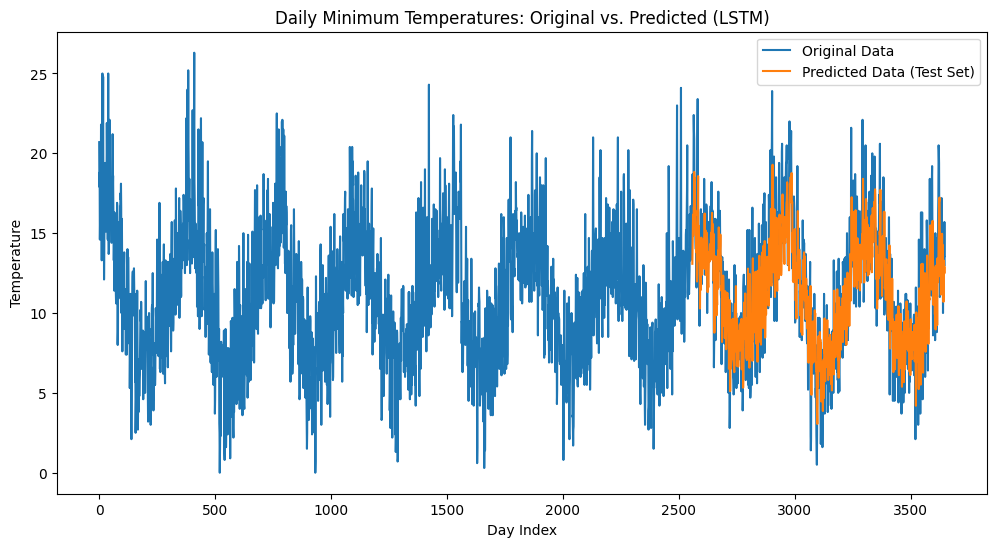

In [6]:
from pandas import read_csv, to_numeric
import pandas as pd
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

NUM_OF_PREV_ITEMS = 5

np.random.seed(1)

# converting csv file into data_frame
data_frame = read_csv('Daily_minimum_temperatures.csv', usecols=[1], header=0, na_values=['?', 'NaN', ' '])

# convert our values into numeric form (they should not be string)
data_frame.iloc[:, 0] = to_numeric(data_frame.iloc[:, 0], errors='coerce')
data_frame.dropna(inplace=True)

# converting our values into float32 for Min max normalisation
data = data_frame.values
data = data.astype('float32')

# Min max normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Calculate the split point
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size

# Split the data
train = data[0:train_size, :]
test = data[train_size:len(data), :]

# showing Training data shape and Testing data shape
print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")


# convert an array of values into a matrix of features that are previous days in data set that would be fed to our model
def reconstruct_data(data, num_of_prev_items):
    x, y = [], []
    for i in range(len(data) - num_of_prev_items - 1):
        a = data[i:i + num_of_prev_items, 0]
        x.append(a)
        y.append(data[i + num_of_prev_items, 0])
    return np.array(x), np.array(y)


# creating training and test data matrix
train_x, train_y = reconstruct_data(train, NUM_OF_PREV_ITEMS)
test_x, test_y = reconstruct_data(test, NUM_OF_PREV_ITEMS)

print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

# reshape input to be [numOfSamples, time steps, numOfFeatures]
# time steps is 1 because we want to predict the next value (t+1)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# creat the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(1, NUM_OF_PREV_ITEMS)))
model.add(Dropout(0.4))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50)) # Last LSTM layer does not return sequences for a many-to-one prediction
model.add(Dropout(0.3))
model.add(Dense(units=1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
model.fit(train_x, train_y, epochs=20, batch_size=32, verbose=2) # Added verbose=2 for cleaner output

# prediction and min max normalization
predicted_y = model.predict(test_x)
predicted_y = scaler.inverse_transform(predicted_y)

# Inverse transform test_y for comparison. Reshape it from (N,) to (N,1)
test_y_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))

# calculating the score
test_score = np.sqrt(mean_squared_error(test_y_unscaled, predicted_y))
print(f'Test Score: {test_score}')

# plot the data (original data and prediction)
predicted_y_plot = np.empty_like(data)
predicted_y_plot[:, :] = np.nan

# Calculate the correct start index for plotting the predictions
# The test data starts at 'train_size' in the original 'data' array.
# The 'reconstruct_data' function effectively "consumes" 'NUM_OF_PREV_ITEMS' + 1 points
# at the beginning of the 'test' set to create the first (test_x, test_y) pair.
# So, the first prediction corresponds to index:
# (train_size) + (NUM_OF_PREV_ITEMS)
plot_start_index = train_size + NUM_OF_PREV_ITEMS + 1 # +1 for the last '-1' in reconstruct_data loop
plot_end_index = plot_start_index + len(predicted_y) # The length of predicted_y is len(test_x)

predicted_y_plot[plot_start_index:plot_end_index, :] = predicted_y

plt.figure(figsize=(12, 6)) # Make the plot larger for better visibility
plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(predicted_y_plot, label='Predicted Data (Test Set)')
plt.title('Daily Minimum Temperatures: Original vs. Predicted (LSTM)')
plt.xlabel('Day Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()